In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d joebeachcapital/realwaste

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/realwaste
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 641M/657M [00:07<00:00, 88.3MB/s]
100% 657M/657M [00:07<00:00, 87.4MB/s]


In [4]:
!unzip -q realwaste.zip -d realwaste

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from glob import glob
from PIL import Image
import shutil


In [26]:
root_dir = "/content/realwaste/realwaste-main/RealWaste"

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [40]:
train_generator = train_datagen.flow_from_directory(
    root_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    root_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 3803 images belonging to 9 classes.
Found 949 images belonging to 9 classes.


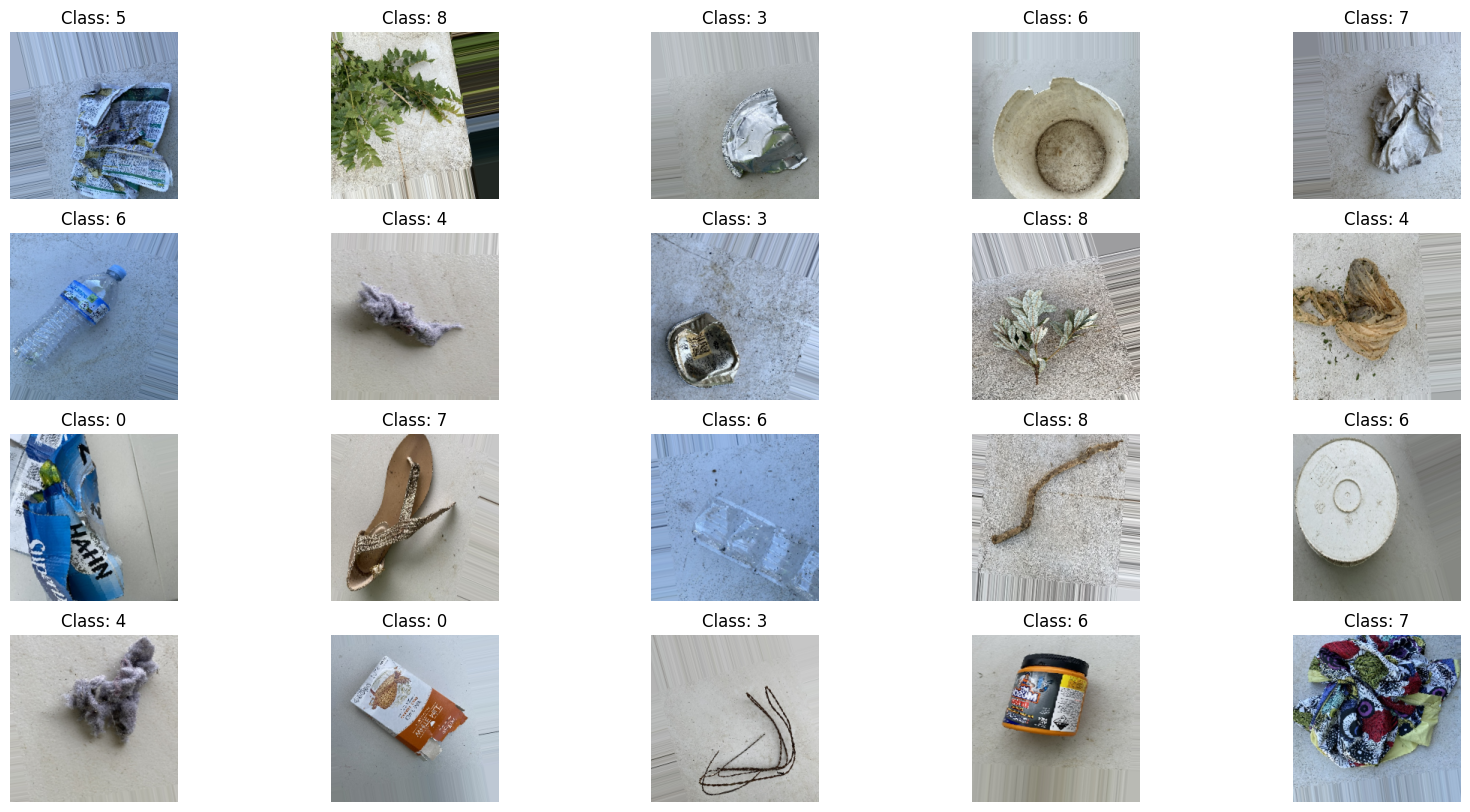

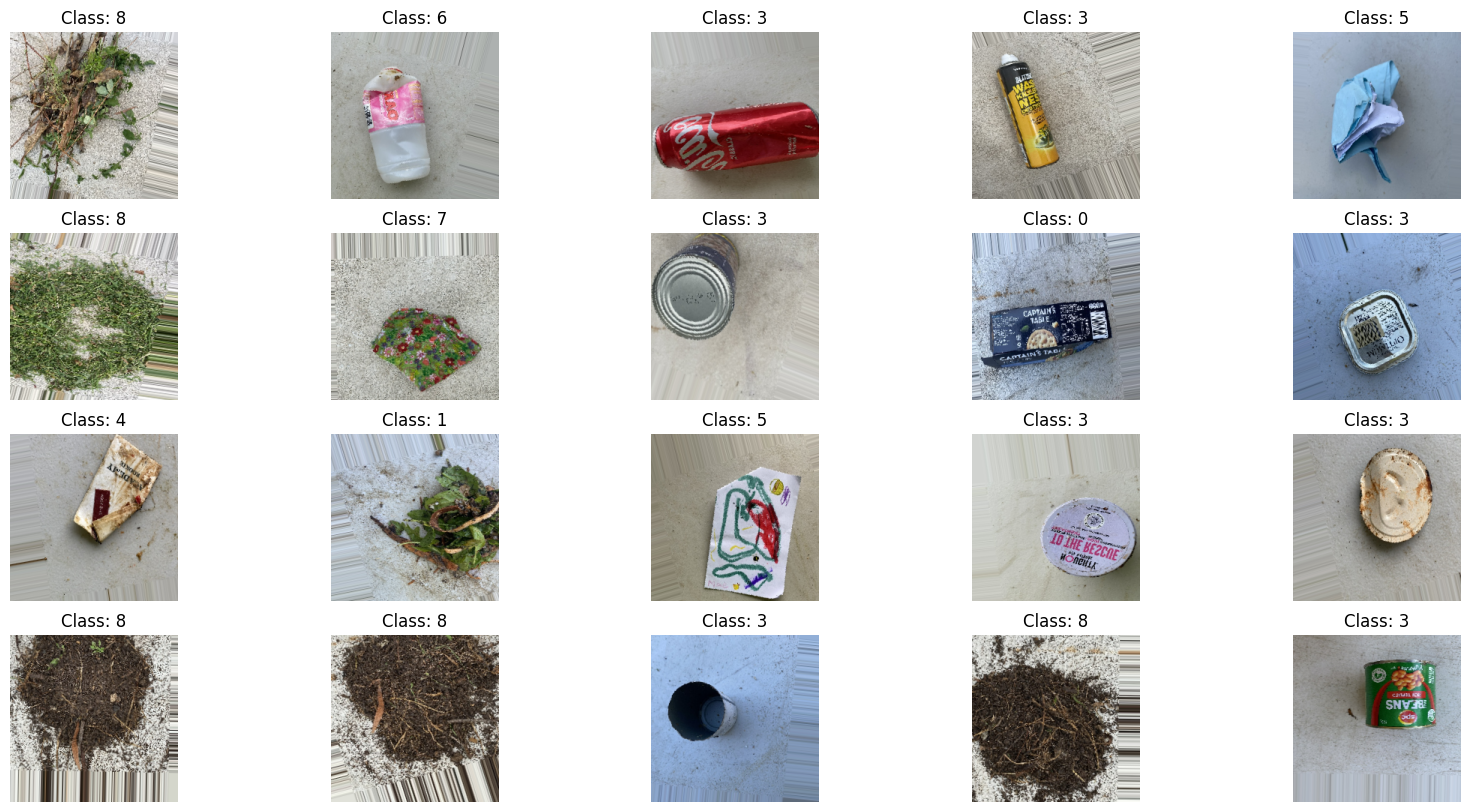

In [ ]:
def visualize(generator, num_images):
    x, y = next(generator)
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(4, 5, i+1)
        plt.imshow(x[i])
        plt.title(f"Class: {y[i].argmax()}")
        plt.axis('off')
    plt.show()

visualize(train_generator, 20)
visualize(validation_generator, 20)


In [42]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [43]:
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 9 classes
])

In [44]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

In [45]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('realwaste_cnn_best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [46]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

model.save('realwaste_cnn_model.h5')


Epoch 1/20
118/118 [==============================] - 94s 721ms/step - loss: 1.7681 - accuracy: 0.3575 - val_loss: 1.6590 - val_accuracy: 0.3696


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
118/118 [==============================] - 74s 626ms/step - loss: 1.4010 - accuracy: 0.4959 - val_loss: 1.5837 - val_accuracy: 0.4289
Epoch 3/20
118/118 [==============================] - 74s 627ms/step - loss: 1.2526 - accuracy: 0.5471 - val_loss: 1.4998 - val_accuracy: 0.4914
Epoch 4/20
118/118 [==============================] - 79s 671ms/step - loss: 1.1650 - accuracy: 0.5993 - val_loss: 1.4646 - val_accuracy: 0.5226
Epoch 5/20
118/118 [==============================] - 79s 672ms/step - loss: 1.1195 - accuracy: 0.6033 - val_loss: 1.4051 - val_accuracy: 0.5065
Epoch 6/20
118/118 [==============================] - 80s 679ms/step - loss: 1.0594 - accuracy: 0.6264 - val_loss: 1.4516 - val_accuracy: 0.4677
Epoch 7/20
118/118 [==============================] - 80s 677ms/step - loss: 1.0224 - accuracy: 0.6386 - val_loss: 1.3226 - val_accuracy: 0.5431
Epoch 8/20
118/118 [==============================] - 79s 674ms/step - loss: 0.9891 - accuracy: 0.6531 - val_loss: 1.3370 - val_ac

In [47]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')

30/30 [==============================] - 19s 650ms/step - loss: 1.2708 - accuracy: 0.5880
Validation accuracy: 58.80%


In [48]:
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

30/30 [==============================] - 15s 486ms/step


In [49]:
from sklearn.metrics import classification_report

class_labels = list(validation_generator.class_indices.keys())
report = classification_report(validation_generator.classes, y_pred, target_names=class_labels)
print(report)

                     precision    recall  f1-score   support

          Cardboard       0.08      0.04      0.06        92
      Food Organics       0.03      0.02      0.03        82
              Glass       0.09      0.07      0.08        84
              Metal       0.20      0.20      0.20       158
Miscellaneous Trash       0.10      0.11      0.10        99
              Paper       0.11      0.09      0.10       100
            Plastic       0.20      0.24      0.22       184
      Textile Trash       0.08      0.11      0.09        63
         Vegetation       0.09      0.10      0.09        87

           accuracy                           0.13       949
          macro avg       0.11      0.11      0.11       949
       weighted avg       0.13      0.13      0.13       949

